# 3. Pipelining and Base Model

In [1]:
import numpy as np
import pandas as pd
import help_functions as hf

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('RTA Dataset.csv')
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [3]:
le.classes_

array(['Fatal injury', 'Serious Injury', 'Slight Injury'], dtype=object)

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    
    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
    #just return self
    def fit(self, X, y=None, **fit_params):
        return self

In [6]:
oe = OrdinalEncoder()
knn_imputer = KNNImputer()
fancy_knn = KNN()
preprocess = FunctionTransformer(hf.preprocess)
encode = FunctionTransformer(hf.encode, kw_args={'encoder': oe})
impute = FunctionTransformer(hf.impute, kw_args={'imputer': knn_imputer})
ohe = OneHotEncoder(handle_unknown='ignore')

In [7]:
oh = make_column_transformer(
    (ohe, hf.cat_col_without_order)
)

In [8]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import TomekLinks, ClusterCentroids
from imblearn.over_sampling import SMOTE, SMOTEN

In [9]:
smote = SMOTE(sampling_strategy='minority', k_neighbors=20)
smoten = SMOTEN(sampling_strategy='minority', k_neighbors=20)
smote_enn = SMOTEENN(smote=smote)
smote_tomek = SMOTETomek(smote=smote)
tomek_links = TomekLinks(sampling_strategy='majority')
cc = ClusterCentroids(sampling_strategy='not minority')

k_best = SelectKBest(k=25, score_func=chi2)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

base_model = LogisticRegression(multi_class='multinomial', max_iter=300)

rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced')
brfc = BalancedRandomForestClassifier(n_estimators=100, class_weight="balanced")
eec = EasyEnsembleClassifier(n_estimators=100)

In [11]:
main_pipe_k_best = imbpipeline([
        ('preprocess', preprocess),                 
        ('encoder', encode),        
        ('impute', impute),
        ('resample', smote),
        ('ohe', oh), 
        ('k_best', k_best),
        ('model', rfc),
    ])

In [12]:
# from sklearn import set_config
# set_config(display='diagram')

# main_pipe_k_best

In [13]:
main_pipe_k_best.fit(X_train, y_train);

In [14]:
y_pred_1 = main_pipe_k_best.predict(X_test)

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
print(classification_report(y_test, y_pred_1, zero_division=0))

              precision    recall  f1-score   support

           0       0.03      0.13      0.05        47
           1       0.15      0.09      0.11       523
           2       0.85      0.87      0.86      3125

    accuracy                           0.75      3695
   macro avg       0.35      0.36      0.34      3695
weighted avg       0.74      0.75      0.74      3695



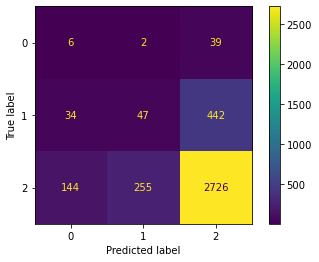

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1);

In [17]:
print('Accuracy Score: ', accuracy_score(y_test, y_pred_1))

Accuracy Score:  0.7520974289580514


In [18]:
main_pipe_k_best['model']

RandomForestClassifier(class_weight='balanced', n_estimators=500)

In [19]:
X_train_prep = pd.DataFrame(data=main_pipe_k_best[:3].transform(X_train))

In [20]:
X_train_prep

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident
0,15.0,1.0,2.0,1.0,4.0,2.0,5.0,10.0,3.0,3.0,...,3.0,4.0,2.0,0.0,1.0,3.0,3.0,2.0,5.0,12.0
1,12.0,3.0,1.0,1.0,4.0,2.0,4.0,0.0,3.0,3.0,...,2.0,2.0,4.0,0.0,1.0,2.0,3.0,2.0,5.0,0.0
2,8.0,1.0,1.0,1.0,4.0,2.0,1.0,8.0,3.0,2.0,...,2.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,5.0,3.0
3,20.0,5.0,2.0,1.0,4.0,2.0,4.0,10.0,3.0,1.0,...,2.0,1.0,2.0,0.0,1.0,3.0,3.0,2.0,5.0,10.0
4,10.0,0.0,2.0,1.0,4.0,0.0,3.0,5.0,3.0,2.0,...,2.0,1.0,2.0,0.0,0.0,2.0,3.0,2.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,19.0,4.0,1.0,1.0,4.0,2.0,3.0,0.0,3.0,2.0,...,3.0,1.0,2.0,0.0,1.0,2.0,3.0,2.0,5.0,12.0
8617,16.0,5.0,1.0,1.0,4.0,0.0,4.0,14.0,3.0,3.0,...,2.0,3.0,2.0,1.0,0.0,0.0,3.0,2.0,5.0,9.0
8618,17.0,0.0,0.0,1.0,4.0,0.0,2.0,5.0,3.0,3.0,...,2.0,1.0,2.0,0.0,1.0,3.0,3.0,2.0,5.0,3.0
8619,17.0,1.0,2.0,1.0,3.0,0.0,3.0,5.0,3.0,4.0,...,2.0,1.0,4.0,1.0,1.0,2.0,3.0,2.0,5.0,14.0


In [21]:
model = main_pipe_k_best['model']

In [22]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train_prep)
shap.summary_plot(shap_values, X_t_prep, plot_type='bar')

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

NameError: name 'X_t_prep' is not defined

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)

# main_pipe_pca = imbpipeline([    
#         ('preprocess', preprocess),                 
#         ('encoder', encode),
#         ('impute', impute),
#         ('resample', smote),
#         ('ohe', ohe),
#         ('to_dense', ToDenseTransformer()),
#         ('pca', pca),
#         ('model', rfc),
#     ])

# main_pipe_pca.fit(X_train, y_train)
# y_pred_2 = main_pipe_pca.predict(X_test)

In [ ]:
# print(classification_report(y_test, y_pred_2))

In [ ]:
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2);

In [ ]:
# print('Accuracy Score: ', accuracy_score(y_test, y_pred_2))